In [1]:
# Get http://geneontology.org/ontology/go-basic.obo
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo(obo="enrichment_analysis/go-basic.obo")


# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
from goatools.base import download_ncbi_associations
fin_gene2go = download_ncbi_associations(gene2go="enrichment_analysis/gene2go")

  EXISTS: enrichment_analysis/go-basic.obo
  EXISTS: enrichment_analysis/gene2go


In [2]:
from goatools.obo_parser import GODag

obodag = GODag("enrichment_analysis/go-basic.obo")

enrichment_analysis/go-basic.obo: fmt(1.2) rel(2023-05-10) 46,490 Terms


In [3]:
from __future__ import print_function
from goatools.anno.genetogo_reader import Gene2GoReader

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[10090])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated mouse genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:05.322068 434,183 annotations, 29,881 genes, 19,173 GOs, 1 taxids READ: enrichment_analysis/gene2go 
MF 17,643 annotated mouse genes
CC 19,357 annotated mouse genes
BP 18,965 annotated mouse genes


In [4]:
import os
import biomart
import pickle as pkl


def get_ensembl_mappings():
    filename = "enrichment_analysis/entrezgene_id_to_gene_symbol.pkl"
    if os.path.exists(filename):
        return pkl.load(open(filename, 'rb'))


    # Set up connection to server                                               
    server = biomart.BiomartServer('http://www.ensembl.org/biomart')         
    mart = server.datasets['mmusculus_gene_ensembl']                            
                                                                                
    # List the types of data we want                                            
    attributes = ['ensembl_transcript_id', 'mgi_symbol', 
                  'ensembl_gene_id', 'entrezgene_id']
                                                                                
    # Get the mapping between the attributes                                    
    response = mart.search({'attributes': attributes})                          
    data = response.raw.data.decode('ascii')                                    
                                                                                
    gene_symbol_to_ensemble = {}                                                  
    # Store the data in a dict                                                  
    for line in data.splitlines():                                              
        line = line.split('\t')                                                 
        # The entries are in the same order as in the `attributes` variable
        transcript_id = line[0]                                                 
        gene_symbol = line[1]                                                   
        ensembl_gene = line[2]                                                  
        entrezgene_id = line[3] 
                                                                                
        # Some of these keys may be an empty string. If you want, you can 
        # avoid having a '' key in your dict by ensuring the 
        # transcript/gene/peptide ids have a nonzero length before
        # adding them to the dict
        gene_symbol_to_ensemble[entrezgene_id] = {
            "transcript_id": transcript_id,
            "ensembl_gene": ensembl_gene,
            "gene_symbol": gene_symbol,
        }

    pkl.dump(gene_symbol_to_ensemble, open(filename, 'wb'))
                                                                                
    return gene_symbol_to_ensemble

mappings = get_ensembl_mappings()

In [5]:
import gseapy as gp
import pandas as pd

def do_enrichment_analysis(genes, background_genes, ontology="BP"):
    bp = ns2assoc[ontology]
    a = {}
    for k in list(bp.keys()):
        if str(k) in mappings.keys():
            a[mappings[str(k)]["gene_symbol"]] = bp[k]

    b = {}
    for k in a:
        for v in a[k]:
            if v not in b:
                b[v] = []
            b[v].append(k)
    
    enr2 = gp.enrich(gene_list=genes,
                 gene_sets=b,
                 background=background_genes, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)
    enr2.results = enr2.results.sort_values("Adjusted P-value")
    go = GODag("enrichment_analysis/go-basic.obo")
    enr2.results["Term"] = enr2.results["Term"].apply(lambda x: go[x].name)

    return enr2

In [6]:
genes = pd.read_csv("../exploratory/outlier_detection/artifacts/final_gene_list.tsv", sep="\t", skiprows=2)["Gene"].reset_index().rename(columns={"index": "Rank"})["Gene"]
genes_top = genes[:500]

In [7]:
enr_BP = do_enrichment_analysis(genes_top, genes, "BP")

2025-01-23 17:12:01,835 [INFO] Input dict object named with gs_ind_0
2025-01-23 17:12:01,836 [INFO] Run: gs_ind_0 
2025-01-23 17:12:02,226 [INFO] Done.


enrichment_analysis/go-basic.obo: fmt(1.2) rel(2023-05-10) 46,490 Terms


In [8]:
enr_MF = do_enrichment_analysis(genes_top, genes, "MF")

2025-01-23 17:12:03,714 [INFO] Input dict object named with gs_ind_0
2025-01-23 17:12:03,716 [INFO] Run: gs_ind_0 
2025-01-23 17:12:03,993 [INFO] Done.


enrichment_analysis/go-basic.obo: fmt(1.2) rel(2023-05-10) 46,490 Terms


In [9]:
enr_CC = do_enrichment_analysis(genes_top, genes, "CC")

2025-01-23 17:12:05,657 [INFO] Input dict object named with gs_ind_0
2025-01-23 17:12:05,658 [INFO] Run: gs_ind_0 
2025-01-23 17:12:05,776 [INFO] Done.


enrichment_analysis/go-basic.obo: fmt(1.2) rel(2023-05-10) 46,490 Terms


In [10]:
enr_CC.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
68,gs_ind_0,nucleus,316/5563,7.844172e-52,3.875021e-49,3.859024,4.541093e+02,Smc3;Gemin8;Fancd2;Gins4;Glrx2;Fanca;Cops6;Skp...
74,gs_ind_0,nucleoplasm,196/3077,4.921955e-33,1.215723e-30,3.145661,2.340107e+02,Smc3;Rad51;Banf1;Sf3b6;Fancd2;Prc1;Glrx2;Atp6v...
99,gs_ind_0,chromosome,66/512,5.376231e-26,8.852861e-24,5.245939,3.052361e+02,Smc3;Mad2l2;Rad51;Ccdc137;Polq;Telo2;Mis18bp1;...
102,gs_ind_0,nucleolus,77/703,1.260669e-25,1.556926e-23,4.519824,2.591350e+02,Wdr75;Fancd2;Mdm2;Rps3;Ddx27;Cenph;Osbp;Wdr43;...
292,gs_ind_0,small-subunit processome,22/48,4.676279e-22,4.620163e-20,17.481013,8.585690e+02,Nop58;Wdr75;Rcl1;Dcaf13;Krr1;Nop56;Dhx37;Pwp2;...
...,...,...,...,...,...,...,...,...
239,gs_ind_0,axon,5/445,9.947710e-01,1.000000e+00,0.439349,2.303404e-03,Car2;Phb2;Zpr1;Crcp;Eif2b2
65,gs_ind_0,basement membrane,1/111,9.559720e-01,1.000000e+00,0.483914,2.178903e-02,Smc3
63,gs_ind_0,extracellular region,12/1661,1.000000e+00,1.000000e+00,0.252844,3.127759e-11,Scgb1b2;Prl2c2;Il13ra2;Prl2c3;Scgb1b24;Pnp2;Li...
121,gs_ind_0,lysosome,4/426,9.977320e-01,1.000000e+00,0.375129,8.517489e-04,Sec13;Sod1;Atp6v1a;Wdr48


In [11]:
enr_pathways = gp.enrichr(gene_list=genes_top.str.upper(),
 gene_sets=['KEGG_2019_Mouse'],
 organism='mouse', 
 outdir='artifacts/tophits',
 cutoff=0.5 
 )
enr_pathways.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Mouse,Ribosome biogenesis in eukaryotes,24/115,8.715135e-16,1.446712e-13,0,0,10.753902,372.905520,NOP56;POP5;WDR36;NOP58;UTP6;NXT1;IMP3;HEATR1;W...
1,KEGG_2019_Mouse,Fanconi anemia pathway,17/51,2.998015e-15,2.488352e-13,0,0,20.151139,673.870725,FANCI;WDR48;FANCM;FANCL;TOP3A;FANCA;FANCC;BRCA...
2,KEGG_2019_Mouse,Homologous recombination,14/41,5.905513e-13,3.267717e-11,0,0,20.775949,585.003348,BARD1;TOP3A;MRE11A;BRCA1;SEM1;RAD50;RAD51D;RAD...
3,KEGG_2019_Mouse,RNA transport,23/167,3.215018e-11,1.334233e-09,0,0,6.481307,156.592280,POP5;EIF2B4;PRMT5;SAP18B;SEC13;EIF2B2;NXT1;RBM...
4,KEGG_2019_Mouse,Proteasome,13/46,6.116397e-11,2.030644e-09,0,0,15.747060,370.330897,PSMD12;PSMD11;POMP;PSMA7;SEM1;PSMB7;PSMD6;PSMC...
5,KEGG_2019_Mouse,RNA polymerase,10/28,7.639035e-10,2.113466e-08,0,0,22.088435,463.693238,POLR3A;POLR2A;POLR3B;POLR1A;POLR1C;POLR2E;POLR...
6,KEGG_2019_Mouse,Nucleotide excision repair,11/43,5.964352e-09,1.414403e-07,0,0,13.685327,259.165412,RFC5;DDB1;RFC3;CDK7;PCNA;RFC2;POLD1;RPA3;POLD2...
7,KEGG_2019_Mouse,DNA replication,10/35,9.131764e-09,1.894841e-07,0,0,15.897959,294.295183,RFC5;RFC3;PCNA;RFC2;PRIM1;POLD1;RPA3;POLD2;MCM...
8,KEGG_2019_Mouse,Spliceosome,17/132,3.377295e-08,6.229233e-07,0,0,5.932937,102.067913,RBM25;RBM8A;SF3B6;SRSF1;CDC5L;THOC2;PRPF19;CRN...
9,KEGG_2019_Mouse,Cell cycle,15/123,4.454069e-07,7.393754e-06,0,0,5.553265,81.212483,PCNA;CDC7;SMC3;SMC1A;RBX1;ANAPC11;ORC5;MAD2L2;...


In [12]:
def format_results(enricher_results):
    df = enricher_results.results.rename(columns={
        "Term": "name",
        "Adjusted P-value": "p_fdr_bh",
        "Overlap": "ratio_in_study"
    }).sort_values(by="p_fdr_bh")
    df["name"] = df["name"].apply(lambda x: x.split("(GO")[0])
    df["study_count"] = df["Genes"].apply(lambda x: len(x.split(";")))
    df = df.iloc[:10,:]

    return df

['Cell cycle', 'Spliceosome', 'DNA replication', 'Nucleotide excision repair', 'RNA polymerase', 'Proteasome', 'RNA transport', 'Homologous recombination', 'Fanconi anemia pathway', 'Ribosome biogenesis in eukaryotes']
['RNA splicing', 'cytoplasmic translation', 'DSB repair via homologous recombination', 'DNA replication', 'mRNA processing', 'ribosomal small subunit biogenesis', 'ribosome biogenesis', 'DNA damage response', 'rRNA processing', 'DNA repair']
['ATP binding', 'DNA binding', 'damaged DNA binding', 'ATP-dependent activity, acting on DNA', 'snoRNA binding', 'helicase activity', 'nucleic acid binding', 'structural constituent of ribosome', "DNA-directed 5'-3' RNA polymerase activity", 'RNA binding']
['proteasome complex', 'cytosolic ribosome', 'DNA-directed RNA polymerase complex', 'site of DSB', 'ribonucleoprotein complex', 'small-subunit processome', 'nucleolus', 'chromosome', 'nucleoplasm', 'nucleus']


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_85132/3557955295.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(fixed_labels, rotation=0, fontsize=fontsize)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_85132/3557955295.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(fixed_labels, rotation=0, fontsize=fontsize)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_85132/3557955295.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(fixed_labels, rotation=0, fontsize=fontsize)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_85132/3557955295.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(fixed_labels, rotation=0, fontsize=fontsize)


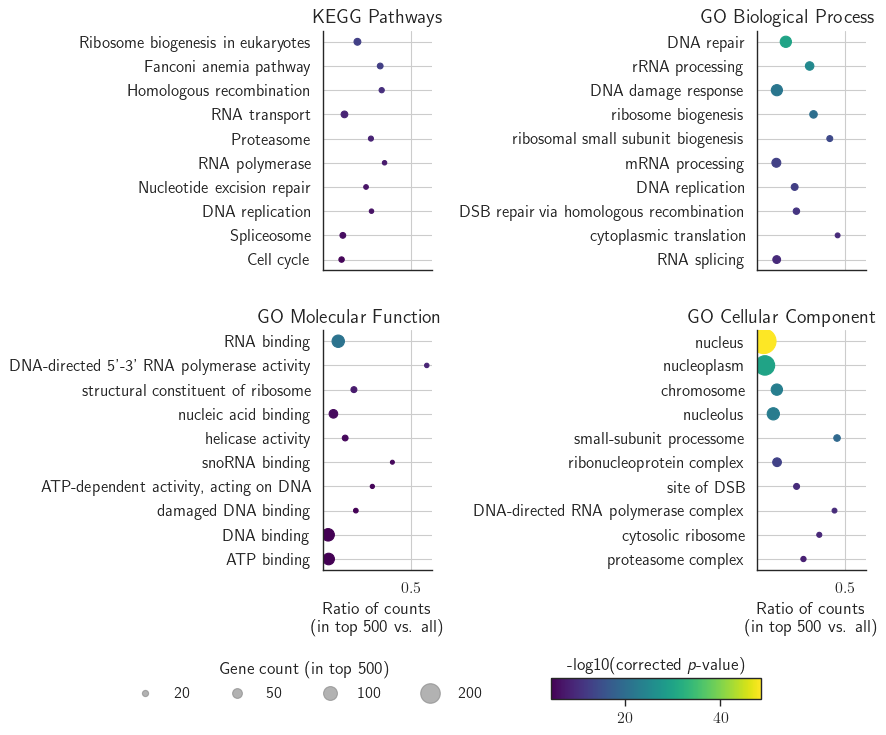

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", palette="muted")
sns.set_context("paper", font_scale = 1.3)

plt.rcParams['text.usetex'] = True

import matplotlib as mpl

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

# tried to imitate the plot seen here: 
# https://www.researchgate.net/figure/Top-10-gene-ontology-GO-and-reactome-pathway-enrichment-analyses-of-226-common-DEGs_fig2_350128204

top10bp = format_results(enr_BP)
top10mf = format_results(enr_MF)
top10cc = format_results(enr_CC)

# not sure if I just want to use goatools. Enrichr seems to exclude parent nodes and only use child nodes
# top10bp = godf.sort_values(by="p_fdr_bh").query("NS == 'BP'").iloc[:10,:]
# top10mf = godf.sort_values(by="p_fdr_bh").query("NS == 'MF'").iloc[:10,:]
# top10cc = godf.sort_values(by="p_fdr_bh").query("NS == 'CC'").iloc[:10,:]
top10keggpathways = format_results(enr_pathways)

def fix_text(s):
    s = s.replace("double-strand break", "DSB")

    # if len(s) > 24:
    #     s1 = s[:24]
    #     s2 = s[24:]
    #     s1 = "\n".join(s1.rsplit(" ", 1))
    #     s = s1 + s2

    return s


def plot_enricher_study_results(df, ax, title, fontsize=12, titlesize=14, vmax=0, vmin=-10):
    df = df.iloc[::-1,:]
    df["ratio_in_study"] = df["ratio_in_study"].apply(eval)
    scatter = ax.scatter(
        y=df["name"], 
        x=df["ratio_in_study"],
        s=df["study_count"],
        c=-np.log10(df["p_fdr_bh"]),
        vmax=vmax,
        vmin=vmin,
        cmap='viridis')
    ax.set_title(title, fontsize=titlesize, loc='right', x=1.1)
    ax.set_xlabel("Ratio of counts\n(in top 500 vs. all)")
    ax.set_xticks([0.5])

    

    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    ticksize = ax.get_yticklabels()[0].get_fontsize()
    # legend2 = ax.legend(handles[::3][:3], labels[::3][:3], loc="upper left", title="Count", frameon=False, bbox_to_anchor=(1, 1.05), fontsize=ticksize)
    # cbar = plt.colorbar(scatter, shrink=0.3, pad=0.3, anchor=(0,0), aspect=8)
    # cbar.ax.set_title("log10(p_cor)", fontsize=ticksize)
    # cbar.ax.tick_params(labelsize=ticksize)

    ax.grid(True)
    fixed_labels = [fix_text(tl.get_text()) for tl in ax.get_yticklabels()]
    print(fixed_labels)
    ax.set_yticklabels(fixed_labels, rotation=0, fontsize=fontsize)

    return scatter

fig, ax = plt.subplots(2, 2, 
                       figsize=(7, 7), 
                       sharex=True)

top10keggpathways["log10(p_value)"] = -np.log10(top10keggpathways["p_fdr_bh"])
top10bp["log10(p_value)"] = -np.log10(top10bp["p_fdr_bh"])
top10mf["log10(p_value)"] = -np.log10(top10mf["p_fdr_bh"])
top10cc["log10(p_value)"] = -np.log10(top10cc["p_fdr_bh"])

max_pvalue = np.max([
    top10keggpathways["log10(p_value)"].max(),
    top10bp["log10(p_value)"].max(),
    top10mf["log10(p_value)"].max(),
    top10cc["log10(p_value)"].max(),
])

min_pvalue = np.min([
    top10keggpathways["log10(p_value)"].min(),
    top10bp["log10(p_value)"].min(),
    top10mf["log10(p_value)"].min(),
    top10cc["log10(p_value)"].min(),
])

scatter = plot_enricher_study_results(top10keggpathways, ax[0,0], "KEGG Pathways", vmax=max_pvalue, vmin=min_pvalue)
plot_enricher_study_results(top10bp, ax[0,1], "GO Biological Process", vmax=max_pvalue, vmin=min_pvalue)
plot_enricher_study_results(top10mf, ax[1,0], "GO Molecular Function", vmax=max_pvalue, vmin=min_pvalue)
plot_enricher_study_results(top10cc, ax[1,1], "GO Cellular Component", vmax=max_pvalue, vmin=min_pvalue)

ax[0,0].set_xlabel(None)
ax[0,1].set_xlabel(None)

# colorplot
fig.subplots_adjust(wspace=3, hspace=0.25)
# cbar_ax = fig.add_axes([0.985, 0.275, 0.03, 0.3])
# fig.colorbar(scatter, aspect=8, cax=cbar_ax, shrink=0.3, pad=0.3, anchor=(0,0))

cbar_ax = fig.add_axes([0.45, -0.075, 0.3, 0.03])
fig.colorbar(scatter, aspect=8, cax=cbar_ax, shrink=0.3, pad=0.3, anchor=(0.5,1), orientation='horizontal')
cbar_ax.set_title(r"-log10(corrected \textit{p}-value)")

# legend
legend_sizes = [20, 50, 100, 200]
legend_handles = [plt.scatter([], [], s=size, color="gray", alpha=0.6) for size in legend_sizes]
legend_labels = [f'{size}' for size in legend_sizes]
fig.legend(legend_handles, legend_labels, loc='upper center', title="Gene count (in top 500)", frameon=False, bbox_to_anchor=(0.1, 0), ncols=4)


# plt.gcf().suptitle("Top 10 GO and KEGG pathway enrichment analyses of top 500 scoring genes", fontsize=16)
# plt.tight_layout()
plt.savefig("./artifacts/GO.pdf", bbox_inches='tight')